In [3]:
from py_cnmf import *
%config InlineBackend.figure_format = 'retina' # make inline images look sharper

### Get tiff form raw files

In [4]:
datadate = '20190902'
filepath = '/mnt/sdb1/TwoPhoton/' + datadate + '/'     # path for saving output    
syncpath = '/mnt/sdb1/sync/' + datadate + '/'          # path for rsync to local folders
workpath = '/mnt/ssd/caiman2f/' + datadate +'/'        # storing tmp files in SSD for fast processing
os.makedirs(filepath, exist_ok=True)
os.makedirs(workpath, exist_ok=True)
os.makedirs(syncpath, exist_ok=True)
raw_path = filepath
f_raws = sorted(glob.glob(raw_path + '*.raw'))  
print(f_raws)

['/mnt/sdb1/TwoPhoton/20190902/Image_001.raw']


In [5]:
l_s = 2000   # number of frames in each tiff, choose smaller value if recording is not stable
             # ideally, the filesize for resulting tiff should be smaller than 2GB
t0 = 1       # innitial frame offset for sliding time window
             # number of overlapping frames for sliding time window averaging
t_ = 1       # time subsampling factor 
             # number of overlapping frames for sliding time window averaging
fr0 = 7.5    # frame rate in raw file
fr = fr0/t_  # frame rate in tiff
n_p = 24     # specify number of processes to use, max = 2*CPUcount

### Stack frames into tiff

In [6]:
if len(glob.glob(workpath + '*.tif'))==0:
    n = 0; nfr = []
    for l in range(len(f_raws)):
        lm = os.stat(f_raws[l]).st_size/2/512**2; # calculate number of images
        if np.ceil(lm)!=np.floor(lm): 
            raise Exception('Rawfile not complete!')        
        tot = int(lm/t_-1) # total number of frames after subsampling, last frame deleted (usually bad)
        n_s = np.ceil(tot/l_s).astype(int) # numbebr of tiffs
        sub = np.ceil(tot/n_s).astype(int) # actual frames in each tiff, slightly smaller than l_s 
        f = open(f_raws[l],'rb'); m = []; m_ = []
        if t0>0: 
            m_.extend(np.fromfile(f, dtype='uint16', count=t0*512**2).reshape(t0,-1))
        for j in range(n_s):
            if j==(n_s-1): sub = tot-j*sub
            for _ in range(sub):
                # temporal averaged image with sliding timewindow across (t0+t_) frames
                m_.extend(np.fromfile(f, dtype = 'uint16', count = t_*512**2).reshape(t_,-1))
                # spatial gaussian filtering
                mm = gaussian_filter(np.mean(m_,0).reshape(512,512), sigma=.5, mode='nearest')
                m.append(np.round(mm).astype('uint16')); 
                m_[:t_] = [] # delete first t_ frame 
            fname = workpath + str(0)*((n<100)+(n<10))+str(n)+'_'+str(tot)+'_'+str(sub)+'_'+str(t_)+'.tif'
            tifffile.imsave(fname, np.array(m)); n+=1; m = []; nfr.append(sub)
        f.close()
    np.save(filepath + 'nfr', nfr) 

### Get the session start time (ses_stt)

So as to transform event marker in each session into the same time axis

In [7]:
nfr = np.load(filepath + 'nfr.npy')   # number of frames for each tiff
lf = len(nfr)                         # number of tiff files
dnfr = np.diff(nfr); dnfr[-1]=0;     
dnfr_= np.array(list(dnfr[1:])+[1]); idxs = abs(dnfr)>0
tseg = np.arange(1,len(nfr))[idxs][dnfr_[idxs]==0] 
snfr = np.insert(np.cumsum(nfr),0,0)  # starting frames for each tiff
ses_stt = np.insert(snfr[tseg],0,0)   # starting frames for each session
print(ses_stt) # [0] if there is only 1 session

[0]


### Get trial start time stamps (aligns)

Needed for extracting data on a trial-by-trial basis

In [8]:
f_mats = sorted(glob.glob(filepath + '*.mat'))
aligns=[]
for l in range(len(f_mats)):
    data = sio.loadmat(f_mats[l])
    align = (data['trial_start'].ravel()-1)/t_
    aligns.extend(align + ses_stt[l])
aligns = np.array(aligns)
print('minITI:', min(np.diff(aligns)), '   L_last:', snfr[-1]-aligns[-1]) 
# minimal inter-trial interval and last trial length should be reasonable

minITI: 61.0    L_last: 1234.0


# 1st MC run

In [11]:
if 'dview' in locals(): cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(backend='local', n_processes=n_p, single_thread=False)

### Run default rigid motion correction

In [12]:
tiffnames = sorted(glob.glob(workpath + '*.tif')) # a list of tiff file names
mc0 = MotionCorrect(tiffnames, dview=dview, max_shifts=(24,24), border_nan='copy', min_mov=0)
# max_shifts: max allowed shift, min_mov: ÷min value of imaging data
mc0.motion_correct() 
np.save(filepath + 'shifts0', np.array(mc0.shifts_rig))

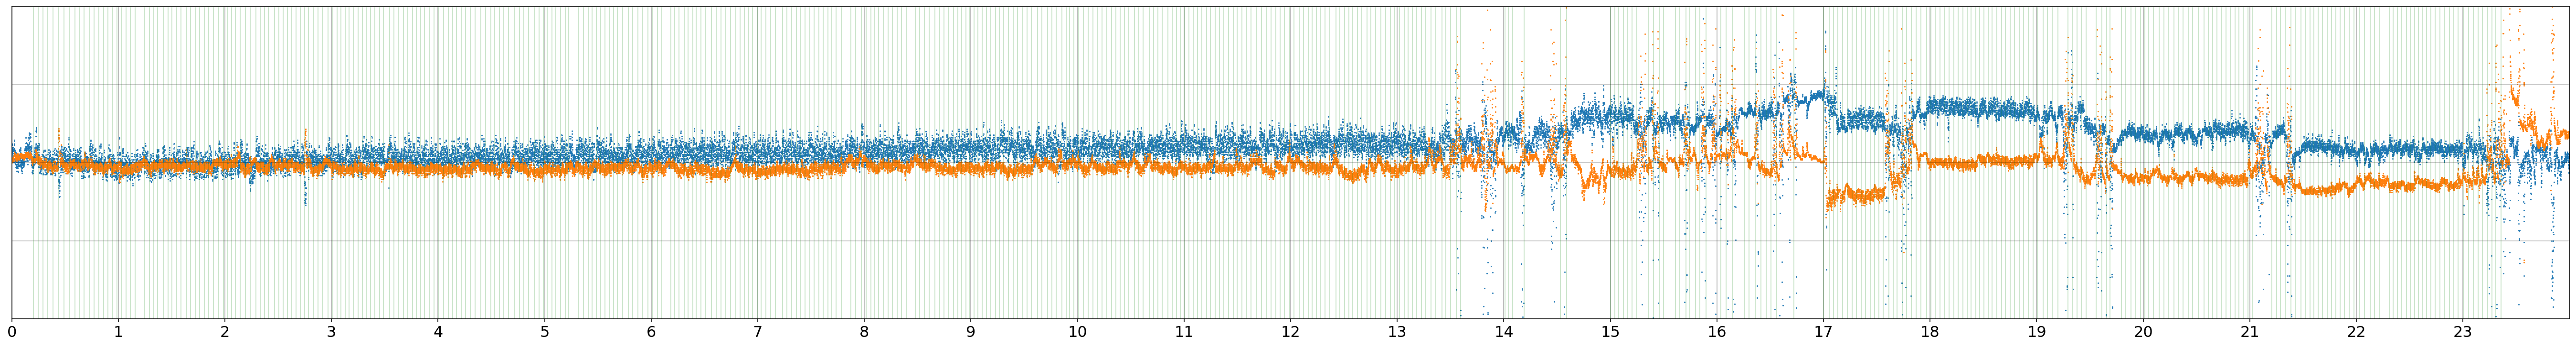

In [13]:
# plot x y shift
xys0 = np.load(filepath + 'shifts0.npy')
xyv0=[]; dxy0=[];  mxy=np.mean(xys0,0)
for i in range(len(nfr)):
    xys_ = xys0[snfr[i]:snfr[i+1]]
    xyv0.append(np.var(xys_[:,0])+np.var(xys_[:,1])); dxy0.append(sum(abs(np.mean(xys_,0) - mxy)))
pf(min(lf*t_*2,290),6)
tR = np.arange(len(xys0)); plt.plot(tR, xys0[tR], '.', ms=1)
for tt in tseg: plt.axvline(snfr[tt], c='C2')
for hh in [-10,0,10]: plt.axhline(hh,lw=.2,c='k')
for t in aligns: plt.axvline(t,c='g',lw=.2)  
plt.xticks(snfr[:-1], np.arange(len(nfr)), fontsize=16)
plt.xlim(tR[0],tR[-1]); plt.yticks([],[]); plt.ylim(-20,20); plt.grid(True)

### Suggesting template to use, consulting the xy shifts

In [14]:
idxv = np.argsort(xyv0)[:15] # 15 candidate with smallest variance
print(idxv) # print suggested template sorted by variance, left is smaller
print(idxv[np.argsort(np.array(dxy0)[idxv])]) # sorted by difference wrt mean shift

[22 18 20  1  4  5  3  8 10  6  7 12  0  2  9]
[10  9 12  8  7  6  5  4  3  2  0  1 22 20 18]


In [15]:
iTemp = 4 # chosen template index

# 2nd MC run

In [16]:
if 'dview' in locals(): cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(backend='local', n_processes=n_p, single_thread=False)
tiffnames = sorted(glob.glob(workpath + '*.tif'))

### Run non-rigid motion correction for template tiff only

In [17]:
mc0 = MotionCorrect([tiffnames[iTemp]], dview=dview, max_shifts=(18,18), max_deviation_rigid=4, strides=(72,72), overlaps=(36,36), border_nan='copy', pw_rigid=True, min_mov=0)
mc0.motion_correct()
np.save(filepath + 'template', mc0.total_template_els) # save the template

### Run non-rigid motion correction for all tiff files wrt the template

In [18]:
template=np.load(filepath + 'template.npy')
mc = MotionCorrect(tiffnames, dview=dview, max_shifts=(24,24), max_deviation_rigid=5, strides=(72,72), overlaps=(36,36), border_nan='copy', pw_rigid=True, min_mov=0)
mc.motion_correct(save_movie=True, template=template)

shifts = np.stack((np.mean(mc.x_shifts_els,1), np.mean(mc.y_shifts_els,1)),0)
np.save(filepath + 'shifts', shifts); cm.stop_server(dview=dview)

### calculate correlation with template for each frame

In [19]:
fnames = mc.mmap_file; tmpl = template.flatten(order='F')
CaS=[]; cor=[]; ys=[]; shs = []; ii=0; n0=int(round(fr)); span=10
# calculated with a sliding timewindow of 'span' second, then interpolate to each frame
sls = [getSlice(shifts[0,snfr[iTemp]:snfr[iTemp+1]], [50,1.5]), getSlice(shifts[1,snfr[iTemp]:snfr[iTemp+1]], [50,1.5])]
# clipping mask to get rid of messy border data, might be minor
for l in range(lf):
    Yr, dims, T = cm.load_memmap(fnames[l])
    CaS.append(np.mean(Yr,1).reshape(dims, order='F'))
    for t in range(T):
        ys.append(Yr[:,t]); shs.append(shifts[:,ii]); ii+=1
        if len(shs)%(span*n0)==0:
            mask = getMask(shs,sls); y = np.mean(ys,0)
            cor.append(pearsonr(y[mask], tmpl[mask])[0]); ys[:n0]=[]; shs[:n0]=[]
tRc = np.arange(len(cor))*n0 + (n0*span-1)/2
f = interpolate.interp1d(tRc, cor, kind='quadratic', bounds_error=False, fill_value=(cor[0],cor[-1]))
np.save(filepath + 'cor', f(np.arange(ii)))

/home/hpy/anaconda3/envs/caiman/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hpy/anaconda3/envs/caiman/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
# xy shifts variance 
xyv=[]; xys = shifts.T; span = 5
for i in range(int(ii/n0)-span+1):
    t_w = range(i*n0,(i+span)*n0); xyv.append(np.var(xys[t_w,0]) + np.var(xys[t_w,1]))
tRv = np.arange(len(xyv))*n0 + (span*n0-1)/2
f = interpolate.interp1d(tRv, xyv, kind='quadratic', bounds_error=False, fill_value=(xyv[0],xyv[-1]))
np.save(filepath + 'xyv', f(np.arange(ii)))     

# chunk-averaged mean images
CaS = np.array(CaS); np.save(filepath + 'CaS', CaS)              
tifffile.imsave(syncpath + 'cas.tif', CaS)    

# correlations between mean images
CaC = np.zeros((lf,lf))
for i in range(lf):
    for j in range(i,lf):
        CaC[i,j] = pearsonr(CaS[i].flatten(), CaS[j].flatten())[0]; CaC[j,i] = CaC[i,j]
np.save(filepath + str(iTemp) + '_CaC', CaC)     

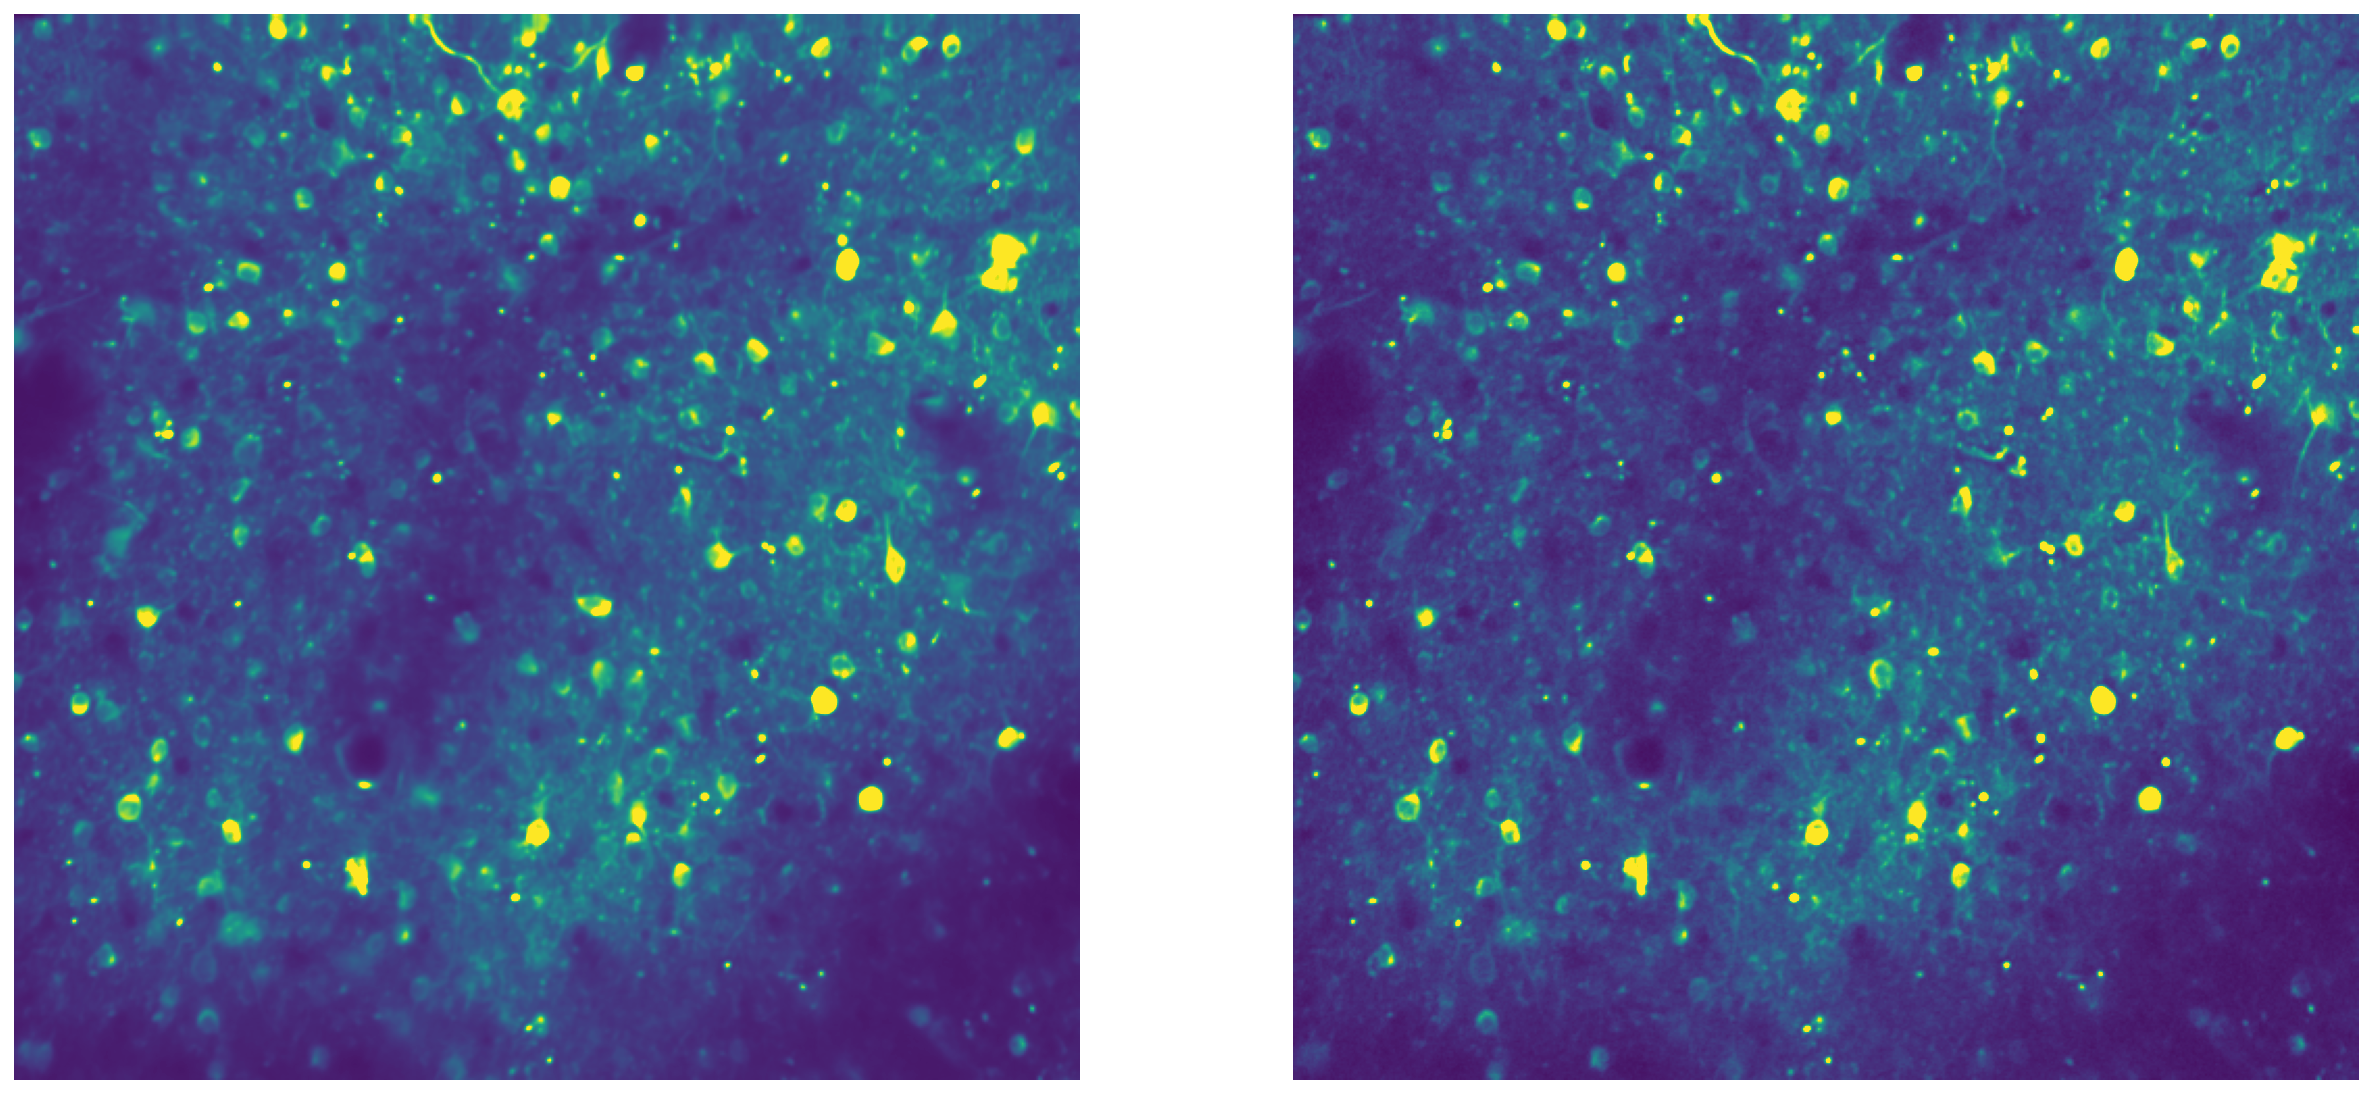

In [21]:
pf(21,10)
Cn = np.load(filepath + 'template.npy'); Ca = np.mean(np.load(filepath + 'CaS.npy'), 0)
plt.subplot(121) # plot averaged image
plt.imshow(Ca, cmap='viridis', vmin=0, vmax=np.percentile(Ca,99)); plt.axis('off');
plt.subplot(122) # plot template
plt.imshow(Cn, cmap='viridis', vmin=0, vmax=np.percentile(Cn,99)); plt.axis('off'); plt.show()

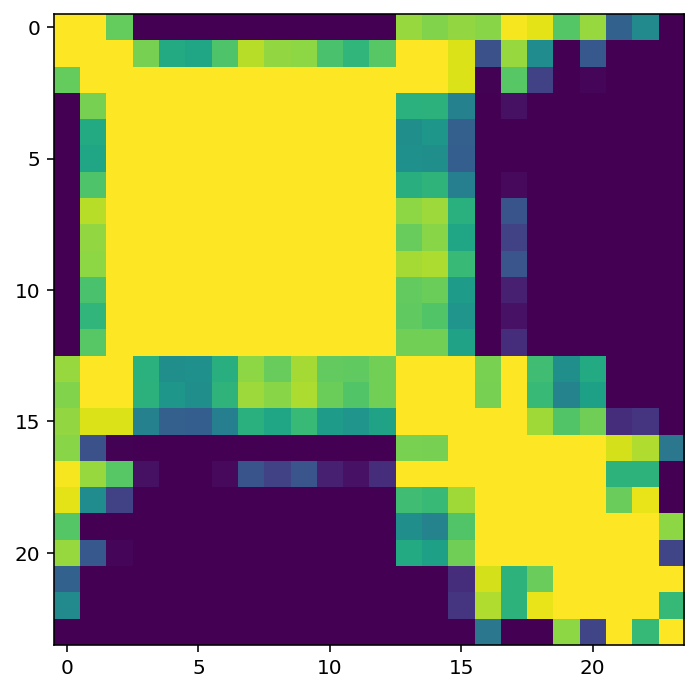

In [22]:
# plot correlation between mean image of each session
CaC = np.load(filepath + str(iTemp) + '_CaC.npy'); lf=len(CaC)
pf(lf/5+1,lf/5+1); plt.imshow(CaC, cmap='viridis', vmin=.85, vmax=.95);
for tt in tseg: plt.axvline(tt-.5,c='r'); plt.axhline(tt-.5,c='r')

4

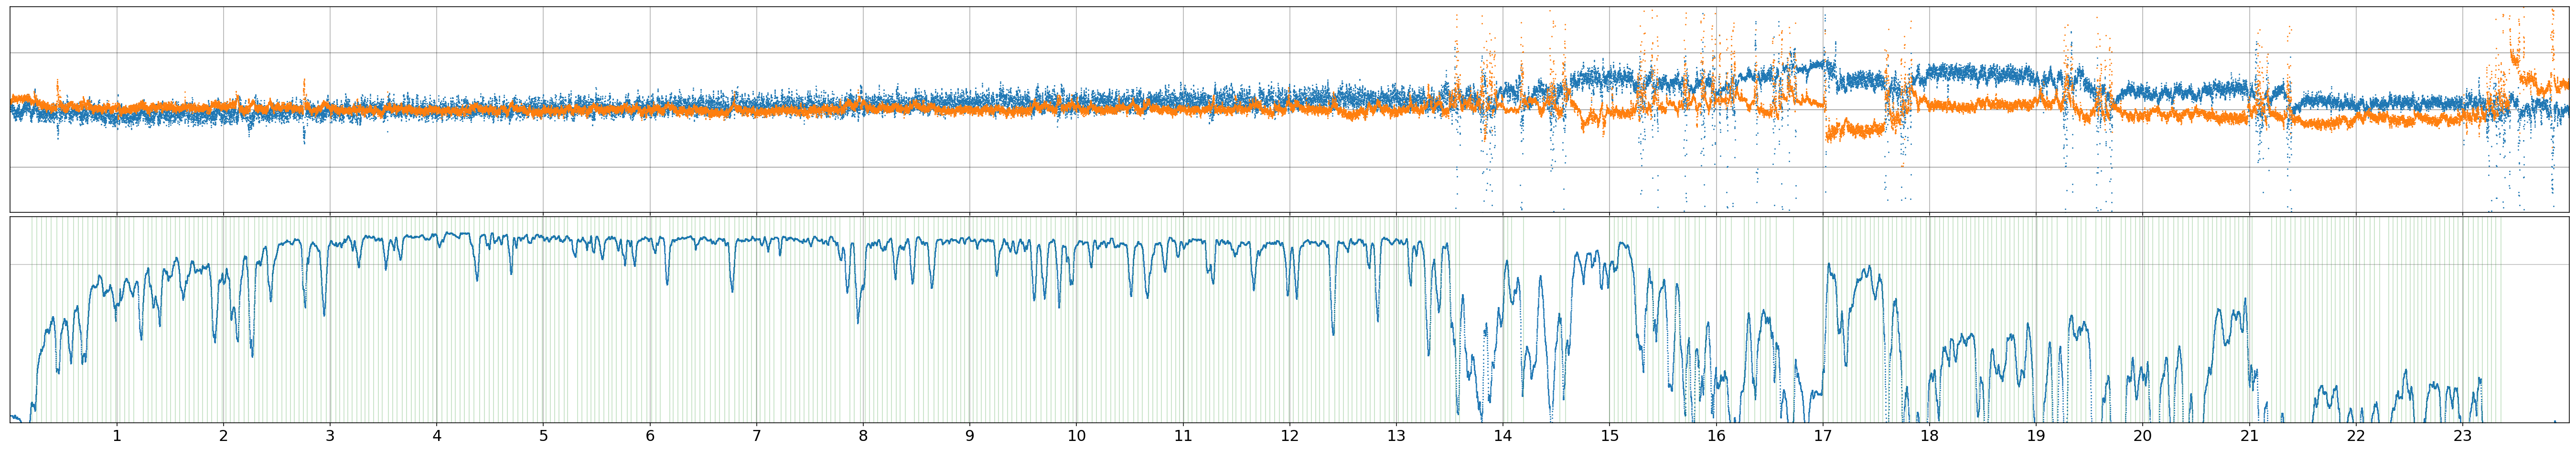

In [23]:
xys = np.load(filepath + 'shifts.npy').T; tR = np.arange(len(xys)); cor = np.load(filepath + 'cor.npy'); 
pf(min(lf*t_*2,288),8); gs = gridspec.GridSpec(2,1); gs.update(hspace=0.02)
plt.subplot(gs[0])
for hh in [-10,0,10]: plt.axhline(hh,lw=.3,c='k'); 
for tt in tseg: plt.axvline(snfr[tt], c='C2')
plt.plot(xys,'.',ms=1); plt.xlim(tR[0],tR[-1]); plt.ylim(-18,18)
plt.yticks([],[]); plt.xticks(snfr[1:-1], []); plt.grid(True);
plt.subplot(gs[1])
plt.plot(cor,'.',ms=1); plt.axhline(.9, lw=.2, c='k')
for t in aligns: plt.axvline(t,c='g',lw=.2)  
plt.xticks(snfr[1:-1], np.arange(1,len(nfr)), fontsize=16)
plt.xlim(tR[0],tR[-1]); plt.yticks([],[]); plt.ylim(bottom=.6); plt.grid(True); iTemp

### choose templates based on correlation with initial template
these templates will be average to form a global template, choose stable sections that spread across time. 

In [10]:
iTemps = [3, 5, 11]
np.save(filepath+'iTemps', iTemps)

# 3rd run

In [12]:
iTemps = np.load(filepath+'iTemps.npy')
iTemp_ = 5 # the best reference template

In [13]:
# if len(glob.glob(workpath + '*.mmap'))!=lf: print('please delete previous mmap files!')
# fnames = sorted(glob.glob(workpath + '*.mmap')) # if start from 3rd run

### calculate correlation with mean template for each frame

In [ ]:
CaS = np.load(filepath + 'CaS.npy')
tmpl = np.mean(CaS[iTemps],0).flatten(order='F') # global template
shifts = np.load(filepath + 'shifts.npy'); 
Xs = np.concatenate([shifts[0,snfr[i]:snfr[i+1]] for i in iTemps]); Ys = np.concatenate([shifts[1,snfr[i]:snfr[i+1]] for i in iTemps])
sls = [getSlice(Xs, [50,1.5]), getSlice(Ys, [50,1.5])]
cor=[]; ys=[]; shs = []; ii=0; n0=int(round(fr)); span=10
for l in range(lf):
    Yr, dims, T = cm.load_memmap(fnames[l])
    for t in range(T):
        ys.append(Yr[:,t]); shs.append(shifts[:,ii]); ii+=1
        if len(shs)%(span*n0)==0:
            mask = getMask(shs, sls); cor.append(pearsonr(np.mean(ys,0)[mask], tmpl[mask])[0]); ys[:n0]=[]; shs[:n0]=[]
f = interpolate.interp1d(np.arange(len(cor))*n0 + (n0*span-1)/2, cor, kind='quadratic', bounds_error=False, fill_value=(cor[0],cor[-1]))
np.save(filepath + 'cor', f(np.arange(ii)))
#  warning about 'Mean of empty slice' can be ignored, as mask edge can be empty in some case

In [14]:
th_ratio = 0.97  # loose threshold ratio based on template correlation 
th_ratio2 = 0.92 # lower bound ratio
sms=[10,20]      # correlation smoothing window length
lw = 10*fr       # typical trial length in seconds
lw_ = fr         # frames to keep before trial start
th_v = 15; th_s =15 # max shift/variance allowed

In [15]:
xyv = np.load(filepath + 'xyv.npy'); xyv_= gaussian_filter(xyv, fr)
cor = np.load(filepath + 'cor.npy'); cor_= cor.copy()
xys = np.load(filepath + 'shifts.npy').T #; xys = np.clip(xys, -20, 20)
xys_ = np.maximum(abs(gaussian_filter(xys[:,0], 5*fr)), abs(gaussian_filter(xys[:,1], 5*fr)))
cor_sm = np.maximum(gaussian_filter(cor, sms[0]*fr), gaussian_filter(cor, sms[1]*fr)); cor_sm_ = cor_sm.copy()

th_base = np.median(cor[snfr[iTemp_]:snfr[iTemp_+1]])
th_1 = th_base*th_ratio; th_2 = th_1*th_ratio2

# manually add some check points
for i in ses_stt: cor_[i] = 0     
for i in np.where(np.diff(aligns) > 4*lw)[0]: cor_sm_[int(aligns[i+1]-lw_)] = 0
idxb_c = cor_ < th_2; idxb_s = (xyv_>th_v) + (xys_>th_s)
cor_sm_[idxb_c+idxb_s] = 0; cor_[idxb_s+idxb_c] = 0; cor[idxb_s] = 0

### Get time windows of stable data

In [15]:
TW, TW_ = getTW(cor, cor_, cor_sm_, th_1, aligns, ses_stt, lw, lw_)
print(sum(np.diff(TW,1)))

[20617.]


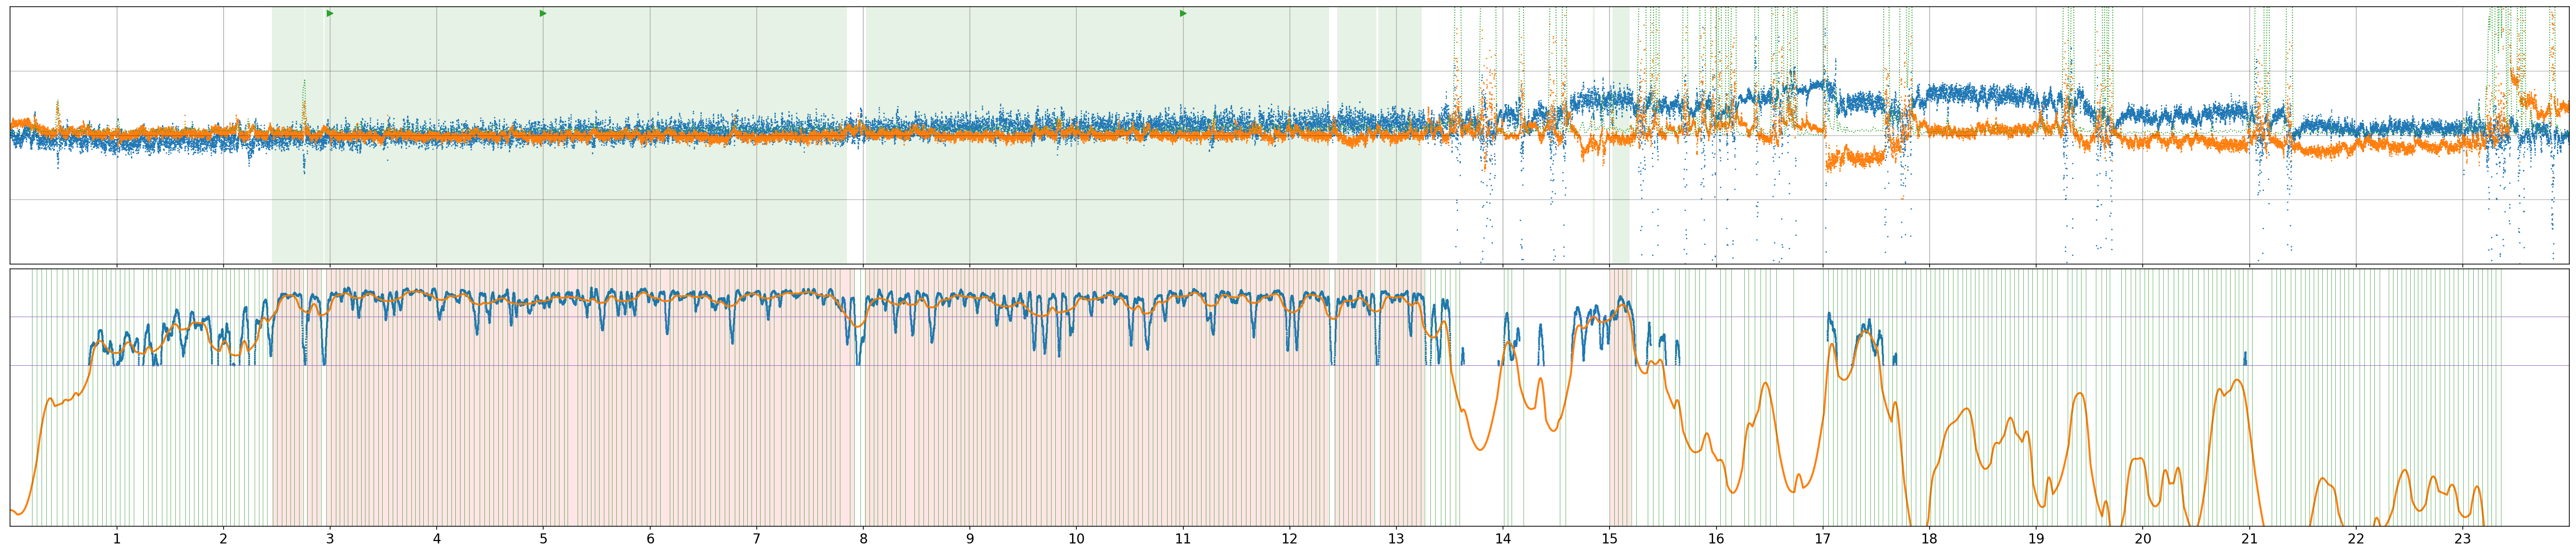

In [29]:
tR = np.arange(len(xys))
pf(min(lf*t_*2,290),10); gs = gridspec.GridSpec(2,1); gs.update(hspace=0.02)
plt.subplot(gs[0]); plt.plot(tR, xys[tR], '.', ms=1); plt.plot(tR, xyv_[tR], ':', lw=1)
for tw in TW_:  plt.axvspan(tw[0],tw[1], color='g', ec='None', alpha=0.1)
for hh in [-10,0,10]: plt.axhline(hh, lw=.2, c='k')
for tmp in iTemps: plt.plot(snfr[tmp], 19, '>', c='C2') # templates are marked
for tt in tseg: plt.axvline(snfr[tt], c='C4')
plt.xticks(snfr[1:-1], [], fontsize=16); plt.grid(True); plt.xlim(tR[0],tR[-1]); plt.yticks([],[]); plt.ylim(-20,20)

plt.subplot(gs[1]); plt.plot(tR, cor_[tR], '.', ms=2); plt.plot(tR, cor_sm[tR],lw=2)
for tw in TW: plt.axvspan(tw[0],tw[1], color='r', ec='None', alpha=0.1)
for t in aligns: plt.axvline(t,c='g',lw=.3)  
for th in [th_1,th_2]: plt.axhline(th,lw=.5,c='C4')
plt.xticks(snfr[1:-1], np.arange(1,len(nfr)), fontsize=14); plt.xlim(tR[0],tR[-1]); plt.yticks([],[]); plt.ylim(.6,.99);
# [os.remove(file) for file in glob.glob(syncpath + 'mc_*')]
# plt.savefig(syncpath + 'mc_' + str(int(th_ratio*1000)) +'_'+str(int(th_ratio2*100))+'_'+str(iTemp_)+'_'+str(int(sum(np.diff(TW_raw,1))))+'.png', bbox_inches='tight', dpi=120)

Top: xy shift (blue, orange), variance (green), templates (triangle), time windows pass 1st threshold (shading)  
Bottom: correlation with different level of smoothing (blue, orange), trial start time (green), final time windows selected trial by trial based on stability (shading)

In [57]:
# # for 4th or 5th runs
# iTemps = [a, b, c]
# np.save(filepath+'iTemps', iTemps)

In [19]:
# recompute the time axis for concatenated tw
TW = np.round(TW).astype(int)
idxt = sum([(aligns>tw[0])*(aligns<tw[1]) for tw in TW]).astype(bool)
Ta = aligns[idxt]; Ta -= TW[0,0]; tused = 0
for i in range(len(TW)-1): 
    tused += TW[i,1]-TW[i,0]; Ta[Ta>tused] -= (TW[i+1,0]-TW[i,1])

# estimate new position of template session
ia = np.where(aligns>(snfr[iTemp_]))[0][0]
tot = np.sum(np.diff(TW,1))
sub = np.ceil(tot/np.ceil(tot/4000)).astype(int)
isuggest = int(round(Ta[ia - sum(~idxt[:ia])]/sub))

In [20]:
try: os.remove(glob.glob(filepath + '*TW.npy')[-1])
except: pass
np.save(filepath + str(iTemp_)+'-'+str(isuggest)+'_'+str(int(th_ratio*1000))+'_'+str(int(th_ratio2*100))+'_'+str(int(sum(np.diff(TW,1))))+'_TW', TW)
np.save(filepath + 'aligns' , Ta); print('# Trials:', len(Ta))
print(glob.glob(filepath + '*TW.npy'))

# Trials: 247
['/mnt/sdb1/TwoPhoton/20190902/5-1_970_92_20620_TW.npy']


In [ ]:
[os.remove(file) for file in fnames]; # delete mmap files